In [1]:
import sys

if "./" not in sys.path:
    sys.path.append("./")
from utils.share import *
import utils.config as config

import einops
import numpy as np
import cv2
import torch
from pytorch_lightning import seed_everything
from annotator.util import HWC3
from models.util import create_model, load_state_dict
from models.ddim_hacked import DDIMSampler
import numpy as np
import os
import re
from src.train.video_warp_dataset import process_flow_with_scaling

/home/maryam.sana/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


logging improved.
Enabled sliced_attention.


In [2]:
from models.util import create_model, load_state_dict
config_path= 'configs/bi_directional_warp/uni_v15.yaml'
ckpt ='experiments/bi_directional_warp/uni.ckpt' 

model = create_model(config_path).cpu()
ckpt = load_state_dict(ckpt, location='cuda')

No module 'xformers'. Proceeding without it.
UniControlNet: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/maryam.sana/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /data/maryam.sana/anaconda3/envs/unicontrolwrap/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
Loaded model config from [configs/bi_directional_warp/uni_v15.yaml]
Loaded state_dict from [experiments/bi_directional_warp/uni.ckpt]


In [3]:
local_images = ['data/sequences/00009/0348/r1.png','data/sequences/00009/0348/depth/im5_depth.png']

flow_path = 'data/sequences/00009/0348/Flow/im5.flo'
local =[] 
for path in local_images:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    local.append(img)

flow = process_flow_with_scaling(flow_path)
prompt = 'a man with hand on this head' 

In [4]:
model = model.cuda()

In [5]:
FE= model.local_adapter.feature_extractor
FE_pre = FE.pre_extractor
wrapper = FE.wrapper

In [6]:
local_conditions = []
for image in local:
        image = cv2.resize(image, (512,512))
        detected_map = HWC3(image)
        local_conditions.append(detected_map)
        
content_emb = np.zeros((768))

detected_maps = np.concatenate([condition for condition in local_conditions], axis=2)
flow_control = torch.from_numpy(flow).float().cuda().unsqueeze(0)
print('flow',flow_control.shape)
local_control = torch.from_numpy(detected_maps.copy()).float().cuda() / 255.0
local_control = torch.stack([local_control for _ in range(1)], dim=0)
local_control = einops.rearrange(local_control, "b h w c -> b c h w").clone()

flow torch.Size([1, 2, 128, 128])


In [7]:
FE_depth = FE.depth_extractor
FE_fusion = FE.fusion

In [8]:
FE_pre = FE_pre.cuda()

In [9]:
frame_features = FE_pre(local_control[:,:3,:,:],None) 

In [10]:
import matplotlib.pyplot as plt
import torch
import os

def visualize_feature_maps(tensor, title="Features", num_channels=4, save_path=None):
    """
    Visualize and optionally save the first `num_channels` feature maps from a tensor.
    
    Args:
        tensor: torch.Tensor of shape [B, C, H, W]
        title: Title prefix for each subplot
        num_channels: Number of channels to visualize (default: 4)
        save_path: If provided, saves the figure to this path (e.g., 'output/features.png')
    """
    assert tensor.ndim == 4, "Tensor must be of shape [B, C, H, W]"
    tensor = tensor.detach().cpu().squeeze(0)  # [C, H, W]

    plt.figure(figsize=(num_channels * 3, 3))
    for i in range(num_channels):
        feature_map = tensor[i]  # [H, W]
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min() + 1e-5)

        plt.subplot(1, num_channels, i + 1)
        plt.imshow(feature_map.numpy(), cmap='gray')
        plt.title(f"{title} - C{i}")
        plt.axis('off')

    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")
    else:
        plt.show()


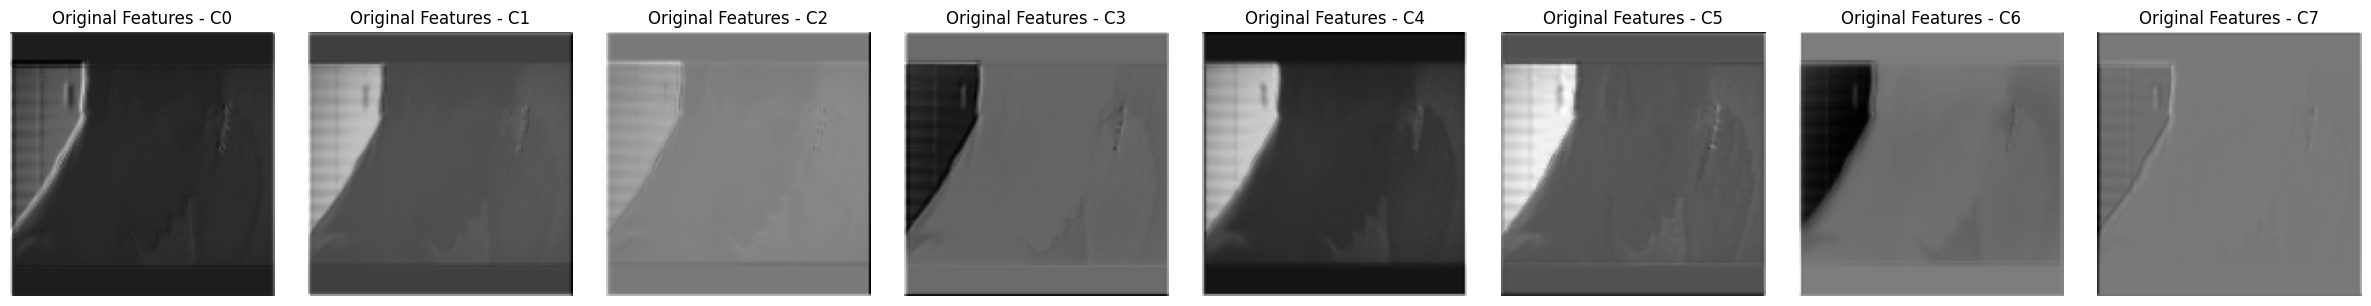

<Figure size 640x480 with 0 Axes>

In [11]:
visualize_feature_maps(frame_features, title="Original Features", num_channels=8)
# visualize_feature_maps(warped_features, title="Warped Features", num_channels=4)
plt.savefig('frame.png')

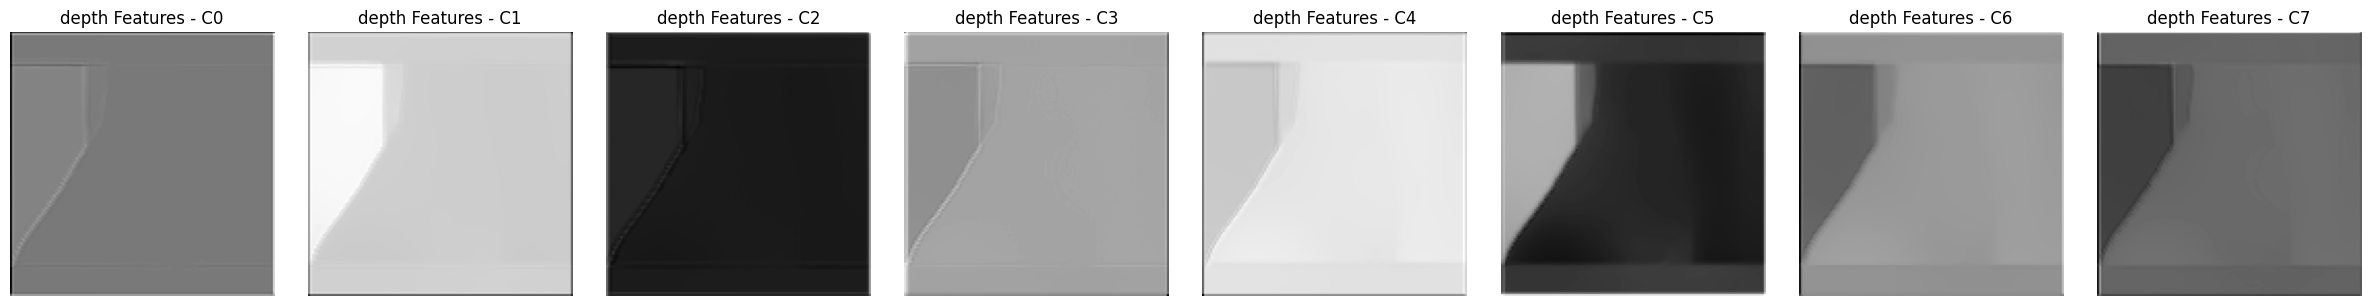

In [12]:
FE_depth = FE_depth.cuda()
depth_features = FE_depth(local_control[:,3:,:,:],None) 
visualize_feature_maps(depth_features, title="depth Features", num_channels=8)

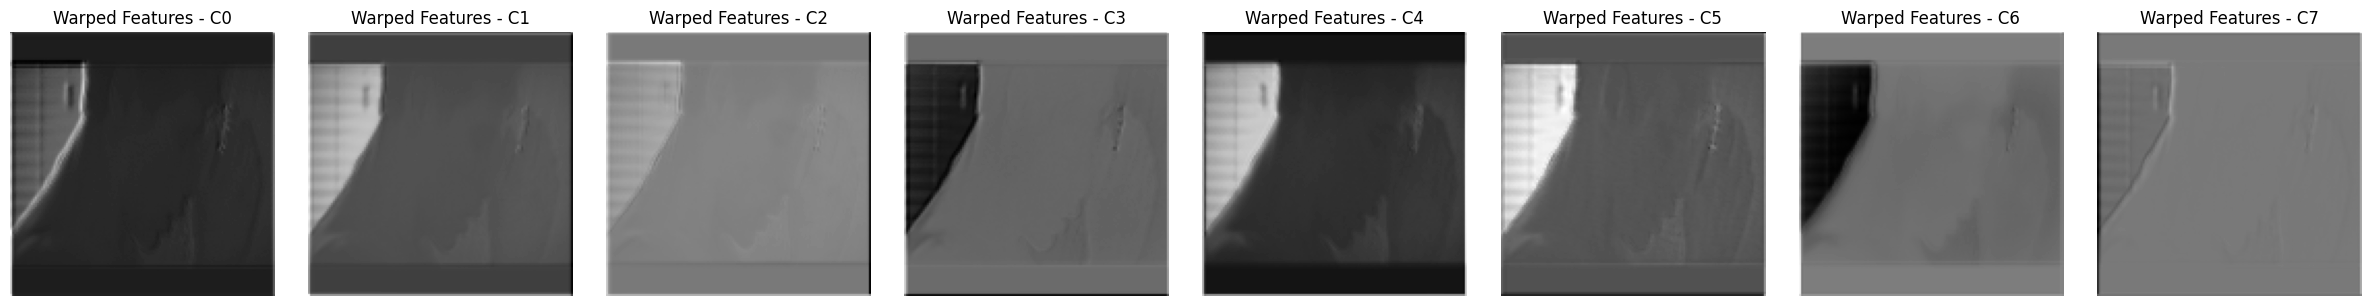

In [13]:
wrapper = wrapper.cuda()
warped_features = wrapper(frame_features, flow_control)
visualize_feature_maps(warped_features, title="Warped Features", num_channels=8)

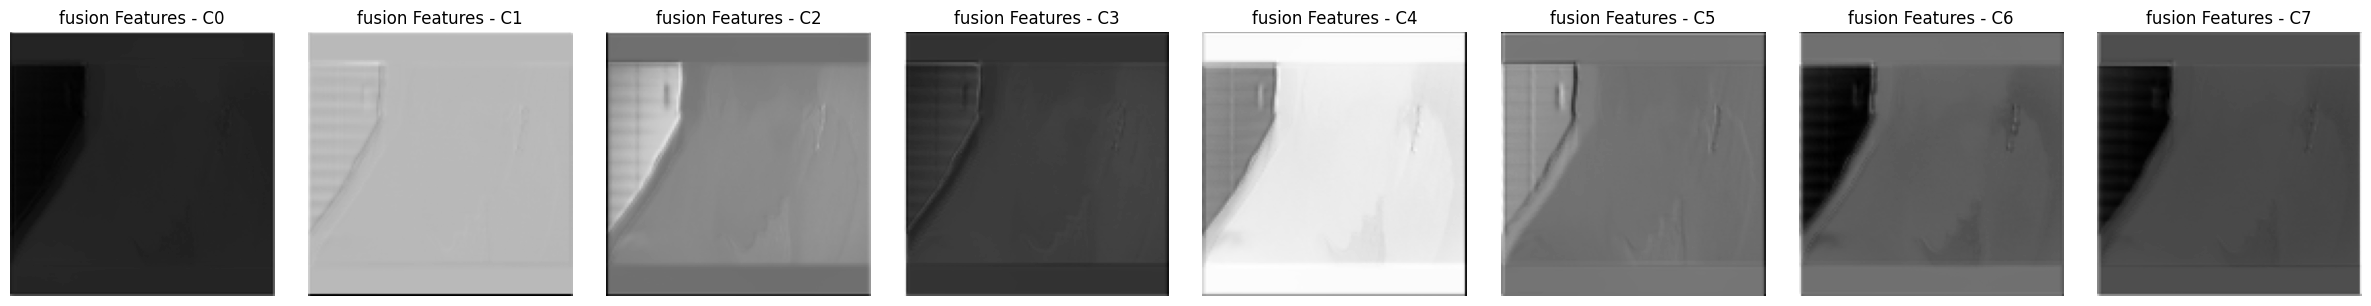

In [14]:
FE_fusion = FE_fusion.cuda()
fused_features = torch.cat([warped_features,depth_features],dim=1)
fusion_ft = FE_fusion(fused_features)
visualize_feature_maps(fusion_ft, title="fusion Features", num_channels=8)

In [15]:
FE = FE.cuda()

out = FE(local_control,flow_control)

shapes torch.Size([1, 128, 128, 128]) torch.Size([1, 2, 128, 128])
Flow min/max: -0.0816565603017807 0.2046690285205841


In [16]:
out[0].shape

torch.Size([1, 192, 64, 64])

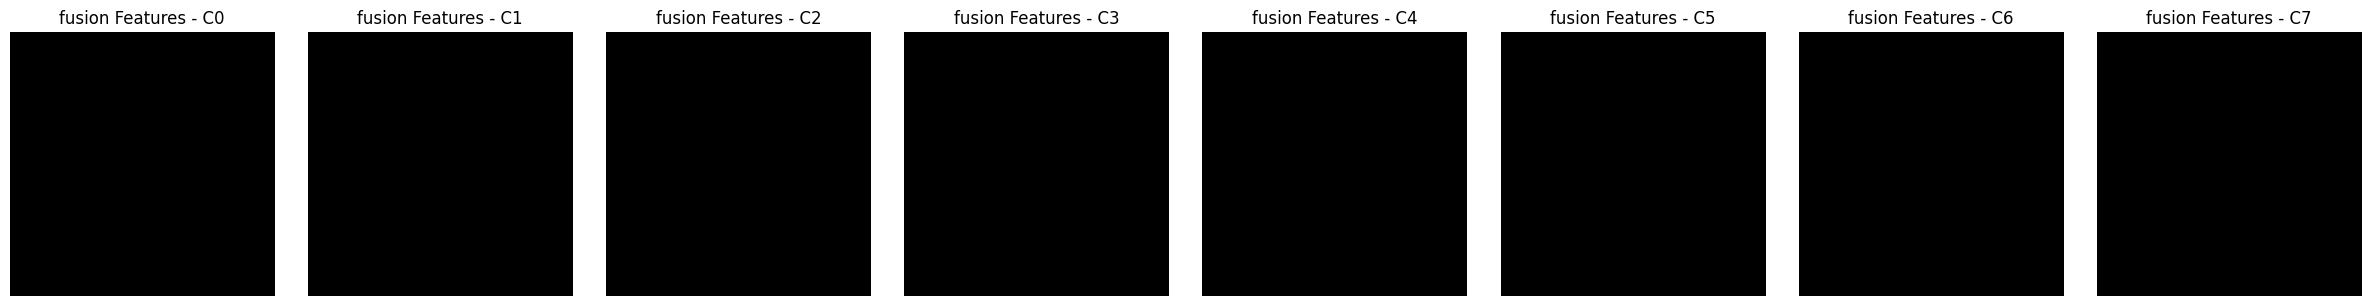

In [17]:
visualize_feature_maps(out[0], title="fusion Features", num_channels=8)

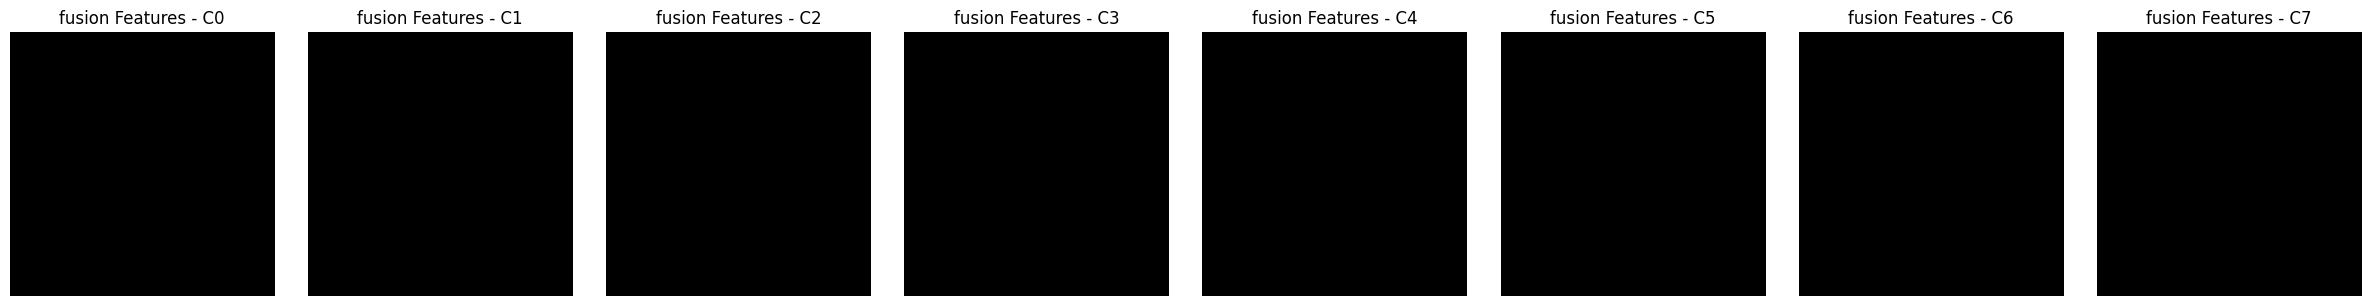

In [18]:
visualize_feature_maps(out[2], title="fusion Features", num_channels=8)